# **Part 2: Modellin -  Isoletion Forest Model (Anomaly detection)**
## Assigement 3 - Group 16
### 36106 - Machine Learning - Autumn 2024

### Sebastian Rodriguez - 24629709

## Context

### 0. Import Packages

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
import numpy as np
import altair as alt

### 1.   Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
csv_link = '/content/drive/MyDrive/Semester 4/Machine Learning /Assigment 3 - Final/preprocessed_dataset3.csv'
data = pd.read_csv(csv_link)

df = data.copy()

### 2. Split and sample dataset

In [ ]:
sampled_df = df.sample(frac=0.10, random_state=42)

In [ ]:
print(sampled_df.shape)

(426090, 24)


In [ ]:
X_sample = sampled_df.drop(columns=['is_fraud'])

In [ ]:
X_sample_scaled = X_sample.copy()

In [ ]:
 s

###3. Finding best parameter for Isolation forest with Gridsearch - No need to run

**Gridsearch was perfom using a sample that corresponded to 10% of the total data. This is code is for reference**

In previous experiment we found that the model was selecting a largue quantity of observations as anomaly. Since our objective is to make the model better at isolating and identifying the most extreme anomalies. We decided to create a custom scoring function to help identify the best hyperparameter for the isolation forest by focusing on the behaviour of the anomaly scores. Therefore,the mean of the lowest 1% anomaly scores was selected as our scoring goal.

By using this approach we helps ensure that the selected hyperparameters lead to a model that is sensitive to the most significant anomalies, which is critical in anomaly detection tasks.

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

In [ ]:
# custom scoring function
def custom_scoring(estimator, X):
    # Get the anomaly scores
    scores = estimator.decision_function(X)
    # Define a simple scoring rule
    threshold = np.percentile(scores, 1)
    mean_score = np.mean(scores[scores < threshold])
    return mean_score

# Parameter grid for GridSearchCV
param_grid = {
    'max_samples': [0.5, 0.75, 1.0],
    'contamination': [0.01, 0.05, 0.1]
}

# Initialize the Isolation Forest model
iso_forest = IsolationForest(random_state=42)

grid_search = GridSearchCV(estimator=iso_forest, param_grid=param_grid, scoring=custom_scoring, cv=5, n_jobs=-1)
grid_search.fit(X_sample_scaled)

# Best parameters and model
best_params = grid_search.best_params_
best_iso_forest = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Best Parameters: {'contamination': 0.01, 'max_samples': 0.5}


### 4. Train Isolation model with best parameters

**Fitting model**

**Best parameters used:**

- **Contamination:** Lower the contamination parameter if it is set too high. This parameter controls the proportion of the data that is considered as anomalies.
-**mac_samples:** Using a value less than 1.0 (as a fraction of the total number of samples) can reduce overfitting.

In [ ]:
df_full = df.copy()

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260904 entries, 0 to 4260903
Data columns (total 23 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amt                      float64
 1   city_pop                 float64
 2   male                     float64
 3   job_group                float64
 4   distance_km              float64
 5   total_daily_spending     float64
 6   quarter                  float64
 7   hour                     float64
 8   category_food_dining     float64
 9   category_gas_transport   float64
 10  category_grocery_net     float64
 11  category_grocery_pos     float64
 12  category_health_fitness  float64
 13  category_home            float64
 14  category_kids_pets       float64
 15  category_misc_net        float64
 16  category_misc_pos        float64
 17  category_personal_care   float64
 18  category_shopping_net    float64
 19  category_shopping_pos    float64
 20  category_travel          float64
 21  age_cate

In [ ]:
df_full = df_full.drop(columns=['is_fraud'])

In [ ]:
# Best parameter were found in previous experiments
best_params = {'contamination': 0.01, 'max_samples': 0.5}

In [ ]:
iso_forest = IsolationForest(**best_params, random_state=0).fit(df_full)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
y_pred = iso_forest.predict(df_full)

In [ ]:
anomaly_scores = iso_forest.decision_function(df_full)

In [ ]:
(y_pred == -1).sum()

42610

**Create a new data frame to with the results**

In [ ]:
results_iso = df_full.copy()

In [ ]:
results_iso['predicted_label'] = y_pred
results_iso['anomaly_score'] = anomaly_scores

**Statitiscal description of the observations lable as anomalies (-1)**

In [ ]:
anomaly_mask = results_iso['predicted_label'] == - 1

In [ ]:
results_iso[anomaly_mask].describe()

,amt,city_pop,male,job_group,distance_km,total_daily_spending,quarter,hour,category_food_dining,category_gas_transport,...,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,age_category_Senior,age_category_Young,predicted_label,anomaly_score
count,42610.000000,42610.000000,42610.000000,42610.000000,42610.000000,42610.000000,42610.000000,42610.000000,42610.000000,42610.000000,...,42610.000000,42610.000000,42610.000000,42610.000000,42610.000000,42610.000000,42610.000000,42610.000000,42610.0,4.261000e+04
mean,2.362757,2.085178,0.073683,-0.518578,-0.190291,2.092960,-0.113526,0.014258,0.018588,-0.014118,...,0.310320,-0.038219,-0.051897,0.116156,-0.018085,0.064466,0.670448,0.103850,-1.0,-2.026184e-02
std,7.408616,2.000146,0.998869,1.097152,1.353382,4.890668,1.066589,1.189093,1.029318,0.978793,...,1.505924,0.930144,0.907359,1.170905,0.975195,1.156621,1.280296,1.045547,0.0,2.177985e-02
min,-0.420076,-0.533153,-0.978892,-1.962792,-2.613996,-0.800770,-1.548144,-1.598319,-0.285431,-0.306192,...,-0.216805,-0.266210,-0.275570,-0.278654,-0.330797,-0.182290,-0.476207,-0.617826,-1.0,-2.521194e-01
25%,-0.295730,-0.210554,-0.978892,-1.629903,-1.401661,-0.435810,-0.632421,-1.142602,-0.285431,-0.306192,...,-0.216805,-0.266210,-0.275570,-0.278654,-0.330797,-0.182290,-0.476207,-0.617826,-1.0,-2.733374e-02
50%,0.052841,1.893671,1.021563,-0.298344,-0.142042,0.268567,0.283302,0.072643,-0.285431,-0.306192,...,-0.216805,-0.266210,-0.275570,-0.278654,-0.330797,-0.182290,-0.476207,-0.617826,-1.0,-1.341976e-02
75%,1.431522,3.863781,1.021563,0.700325,0.979534,2.465165,1.199025,1.135982,-0.285431,-0.306192,...,-0.216805,-0.266210,-0.275570,-0.278654,-0.330797,-0.182290,2.099928,1.618580,-1.0,-5.496875e-03
max,254.756760,4.569511,1.021563,1.033215,2.537853,76.063276,1.199025,1.895510,3.503470,3.265924,...,4.612437,3.756437,3.628848,3.588674,3.023002,5.485779,2.099928,1.618580,-1.0,-2.985207e-08


Observations:
The statistical analysis of thoses obervation labeled as anomalie show a higher value in both transactions and total daily spending, it also occurs in cities with an average higher population.It also suggest that an abnormal transaction occurs more during the evening and late hours.

In [ ]:
results_iso[~anomaly_mask].describe()

,amt,city_pop,male,job_group,distance_km,total_daily_spending,quarter,hour,category_food_dining,category_gas_transport,...,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,age_category_Senior,age_category_Young,predicted_label,anomaly_score
count,4.218294e+06,4.218294e+06,4.218294e+06,4.218294e+06,4.218294e+06,4.218294e+06,4.218294e+06,4.218294e+06,4.218294e+06,4.218294e+06,...,4.218294e+06,4.218294e+06,4.218294e+06,4.218294e+06,4.218294e+06,4.218294e+06,4.218294e+06,4.218294e+06,4218294.0,4.218294e+06
mean,-2.386678e-02,-2.106289e-02,-7.442854e-04,5.238278e-03,1.922171e-03,-2.114149e-02,1.146750e-03,-1.440276e-04,-1.877591e-04,1.426141e-04,...,-3.134618e-03,3.860571e-04,5.242252e-04,-1.173320e-03,1.826848e-04,-6.511901e-04,-6.772357e-03,-1.049009e-03,1.0,8.824964e-02
std,6.314433e-01,9.619397e-01,9.999840e-01,9.975964e-01,9.956056e-01,8.507667e-01,9.992392e-01,9.979064e-01,9.996979e-01,1.000211e+00,...,9.930820e-01,1.000674e+00,1.000879e+00,9.980557e-01,1.000246e+00,9.982716e-01,9.944637e-01,9.994745e-01,0.0,2.784252e-02
min,-4.200759e-01,-5.331528e-01,-9.788920e-01,-1.962792e+00,-2.616665e+00,-8.007883e-01,-1.548144e+00,-1.598319e+00,-2.854313e-01,-3.061920e-01,...,-2.168051e-01,-2.662097e-01,-2.755696e-01,-2.786545e-01,-3.307970e-01,-1.822895e-01,-4.762069e-01,-6.178255e-01,1.0,9.652170e-07
25%,-3.701521e-01,-4.983772e-01,-9.788920e-01,-6.312336e-01,-7.093465e-01,-5.343246e-01,-6.324210e-01,-8.387909e-01,-2.854313e-01,-3.061920e-01,...,-2.168051e-01,-2.662097e-01,-2.755696e-01,-2.786545e-01,-3.307970e-01,-1.822895e-01,-4.762069e-01,-6.178255e-01,1.0,7.120396e-02
50%,-1.528477e-01,-4.169040e-01,-9.788920e-01,7.003251e-01,7.689234e-02,-2.665090e-01,2.833020e-01,-7.926282e-02,-2.854313e-01,-3.061920e-01,...,-2.168051e-01,-2.662097e-01,-2.755696e-01,-2.786545e-01,-3.307970e-01,-1.822895e-01,-4.762069e-01,-6.178255e-01,1.0,9.105361e-02
75%,7.508404e-02,-1.144601e-01,1.021563e+00,7.003251e-01,7.663052e-01,1.892885e-01,1.199025e+00,8.321708e-01,-2.854313e-01,-3.061920e-01,...,-2.168051e-01,-2.662097e-01,-2.755696e-01,-2.786545e-01,-3.307970e-01,-1.822895e-01,-4.762069e-01,1.618580e+00,1.0,1.079007e-01
max,4.547323e+01,4.569511e+00,1.021563e+00,1.033215e+00,2.585087e+00,2.602779e+01,1.199025e+00,1.895510e+00,3.503470e+00,3.265924e+00,...,4.612437e+00,3.756437e+00,3.628848e+00,3.588674e+00,3.023002e+00,5.485779e+00,2.099928e+00,1.618580e+00,1.0,1.593480e-01


Observations:

Transcations labeled as normal have a lower transaction and total daily speding value, customer live in a small city and the hours of transaction occure during the day.

### 5. Model evaluation and interpretation

**Anomaly scores distribution**

These scores indicate how isolated a data point is, thus,  higher scores (more negative) indicate more significant anomalies. These transactions should be prioritized for investigation.

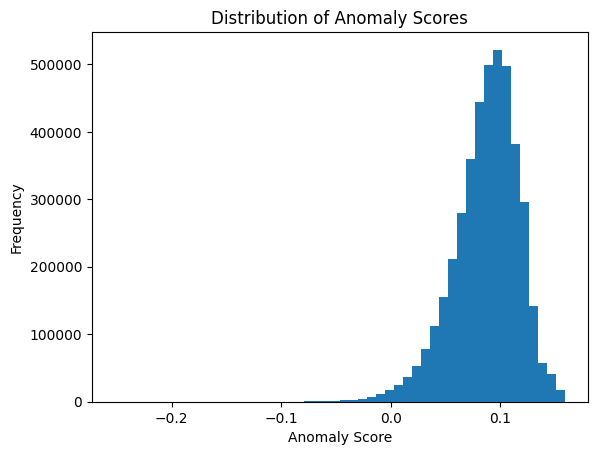

In [ ]:
plt.hist(anomaly_scores, bins=50)
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

**Setting a threshold to Identify anomalies**

The model might label a lot of transactions as anomalies when they are not. Therefore,classifying data points as anomalies, it is a good idea to set an appropriate threshold on the anomaly scores (based on the distribution of the anomaly score). In order to, find a balance between detecting true anomalies and minimizing false positives, and help banks allocate resources into priorityzing anomalies with higher significant score.

In [ ]:
chosen_threshold = -0.04

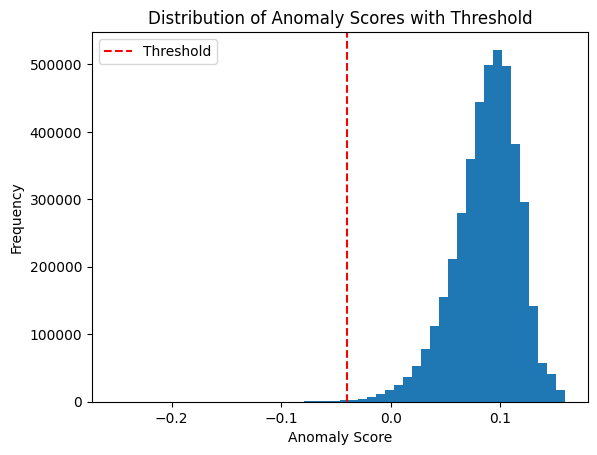

In [ ]:
plt.hist(anomaly_scores, bins=50)
plt.axvline(chosen_threshold, color='r', linestyle='--', label='Threshold')
plt.title("Distribution of Anomaly Scores with Threshold")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
threshold = chosen_threshold

anomalies = results_iso[results_iso['anomaly_score'] < threshold]
anomaly_proportion = len(anomalies) / len(results_iso)

print(f"Number of anomalies: {len(anomalies)}")
print(f"Proportion of anomalies: {anomaly_proportion:.4f}")

Number of anomalies: 5831
Proportion of anomalies: 0.0014


**Visualizing anomalies vs normal transactions**

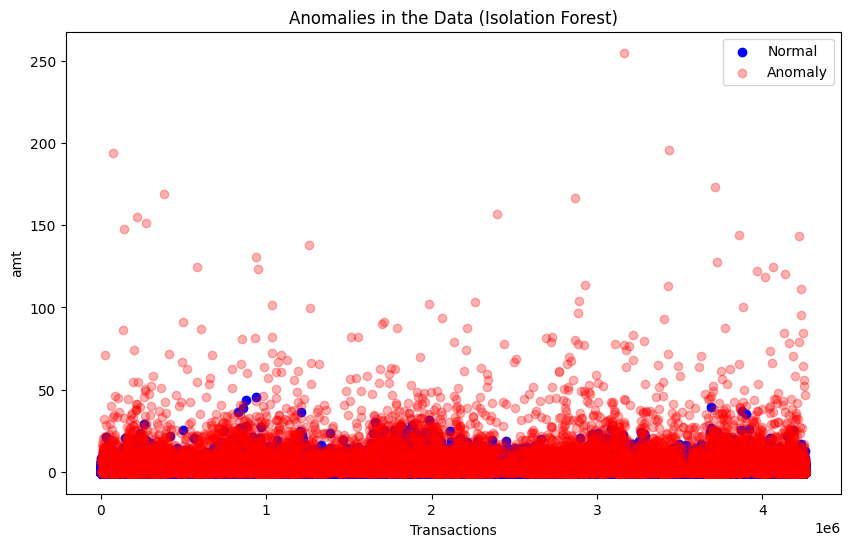

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(results_iso[results_iso['predicted_label'] == 1].index,
            results_iso[results_iso['predicted_label'] == 1]['amt'],
            c='blue', label='Normal')
plt.scatter(results_iso[results_iso['predicted_label'] == -1].index,
            results_iso[results_iso['predicted_label'] == -1]['amt'],
            c='red', alpha=0.3, label='Anomaly')
plt.legend()
plt.xlabel('Transactions')
plt.ylabel('amt')
plt.title('Anomalies in the Data (Isolation Forest)')
plt.show()


**Top anomalies (Total daily spending and Transactions)**

---



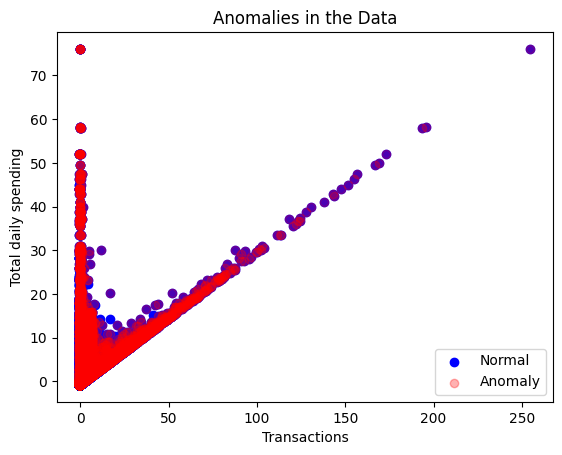

In [ ]:
plt.scatter(results_iso['amt'], results_iso['total_daily_spending'], c='blue', label='Normal')
plt.scatter(anomalies['amt'], anomalies['total_daily_spending'], c='red',alpha= 0.3, label='Anomaly')
plt.legend()
plt.xlabel('Transactions')
plt.ylabel('Total daily spending')
plt.title('Anomalies in the Data')
plt.show()

Observations:

This plot helps visualize if higher transaction amounts correlate with higher daily spending, and highlights any outliers.

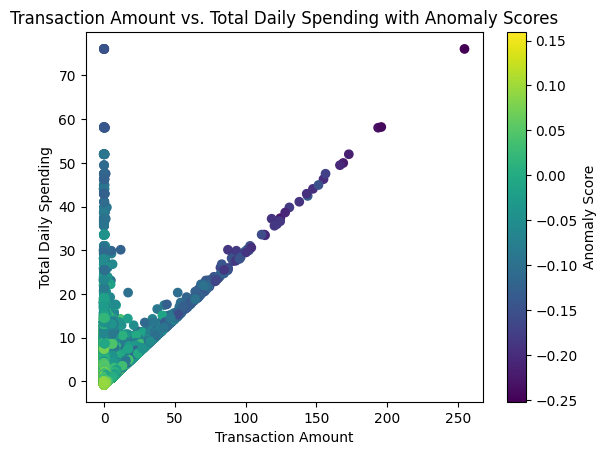

In [ ]:
#Visualize anomalies (assuming you have two main features to plot)
plt.scatter(results_iso['amt'], results_iso['total_daily_spending'], c=results_iso['anomaly_score'], cmap='viridis')
plt.colorbar(label='Anomaly Score')
plt.xlabel('Transaction Amount')
plt.ylabel('Total Daily Spending')
plt.title('Transaction Amount vs. Total Daily Spending with Anomaly Scores')
plt.show()

Observation: When comparing the predicted lables and the anomalie score, we can observe the severity of the anomalies matches with those observation labeled as anomalie.

**Top anomalies (distance km vs transaction amount)**

---



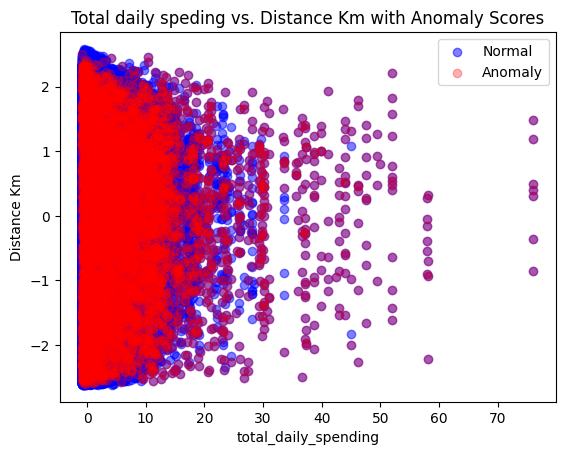

In [ ]:
# Visualize anomalise
plt.scatter(results_iso['total_daily_spending'], results_iso['distance_km'], c='blue',alpha= 0.5, label='Normal')
plt.scatter(anomalies['total_daily_spending'], anomalies['distance_km'], c='red',alpha= 0.3, label='Anomaly')
plt.legend()
plt.xlabel('total_daily_spending')
plt.ylabel('Distance Km')
plt.title('Total daily speding vs. Distance Km with Anomaly Scores')
plt.show()

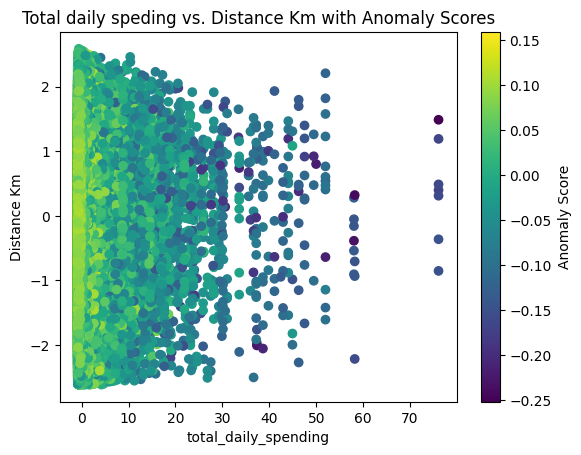

In [ ]:
plt.scatter(results_iso['total_daily_spending'], results_iso['distance_km'], c=results_iso['anomaly_score'], cmap='viridis')
plt.colorbar(label='Anomaly Score')
plt.xlabel('total_daily_spending')
plt.ylabel('Distance Km')
plt.title('Total daily speding vs. Distance Km with Anomaly Scores')
plt.show()

Observations:

This plot helps detect if there are any high-value transactions occurring at unusual distances, which might indicate fraud or anomalies. However, it also consider anomalie low-value transactions.

**Top anomalies (Hour of transcation vs transction amount)**

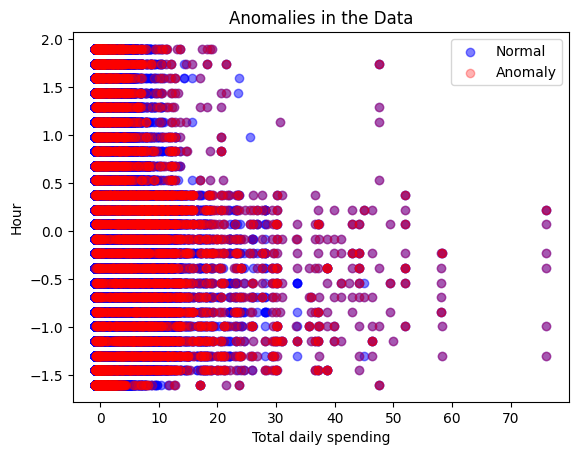

In [ ]:
# Visualize anomalise
plt.scatter(results_iso['total_daily_spending'], results_iso['hour'], c='blue',alpha= 0.5, label='Normal')
plt.scatter(anomalies['total_daily_spending'], anomalies['hour'], c='red',alpha= 0.3, label='Anomaly')
plt.legend()
plt.xlabel('Total daily spending')
plt.ylabel('Hour')
plt.title('Anomalies in the Data')
plt.show()

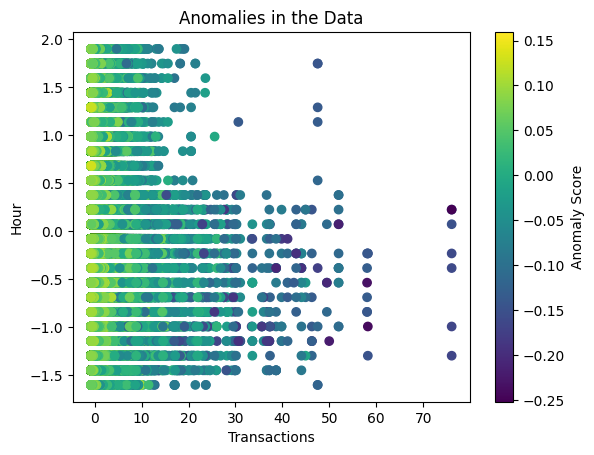

In [ ]:
plt.scatter(results_iso['total_daily_spending'], results_iso['hour'], c=results_iso['anomaly_score'], cmap='viridis')
plt.colorbar(label='Anomaly Score')
plt.xlabel('Transactions')
plt.ylabel('Hour')
plt.title('Anomalies in the Data')
plt.show()

**Analysing the proportion of anomalies by hour**

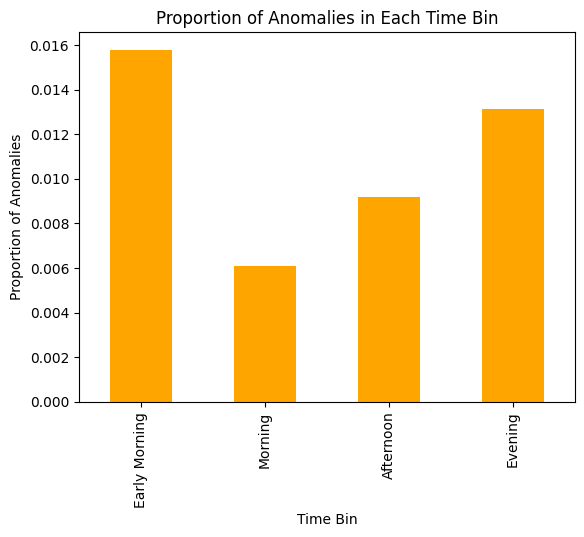

In [ ]:
# Calculate proportion of anomalies per time bin
results_iso['time_bin'] = pd.cut(results_iso['hour'], bins=[-np.inf, -1, 0, 1, np.inf], labels=['Early Morning', 'Morning', 'Afternoon', 'Evening'])
time_bin_anomalies = results_iso.groupby('time_bin')['predicted_label'].apply(lambda x: (x == -1).mean())

# Plot proportion of anomalies in each time bin
time_bin_anomalies.plot(kind='bar', color='orange')
plt.xlabel('Time Bin')
plt.ylabel('Proportion of Anomalies')
plt.title('Proportion of Anomalies in Each Time Bin')
plt.show()

Observation:

This plot helps identify unusual spending patterns based on the time of day, showing if anomalies are occurring at specific hours. As seen before a great number of anomalies occuer during late eveing and early morning, which are the times of the day with less surveillance.